## GARCH Model

### Description:

In this notebook we will implement the code for a **GARCH Model** in order to make Financial **Time Series Forecasting**.

Most of the notebook will be the same as in the **ARIMA** notebook, since the pre-process the the series must have is quite similar.

As explained in the **SeriesAnalysis** notebook, this notebook will use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself.

### GARCH Model Brief Introduction

## COMPLETE

In [1]:
### Some useful functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import sklearn.metrics

np.random.seed(0)

import warnings
warnings.filterwarnings(action='ignore')
warnings

### Some useful functions


In [2]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value,freq):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=plt.xlim()[0],y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    me = np.mean(predicted.values - actual.values)  # ME
    mae = sklearn.metrics.median_absolute_error(actual,predicted)    # MAE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual,predicted))  # RMSE
    
    errors = [['ME',me],['MAE',mae],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors



In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close','w')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close','w')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close','w')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Train and Test Split

In [4]:
largest_horizon = 12 # 12 weeks, 3 months

train_American_diff1, test_American_diff1 = train_test(AmericanAirlines_serie_diff1,12)
train_USD_CAD_diff1, test_USD_CAD_diff1 = train_test(USD_CAD_serie_diff1,12)
train_USD_BRL_diff1, test_USD_BRL_diff1 = train_test(USD_BRL_serie_diff1,12)

## Fit ARIMA+GARCH Model

In [9]:
arima_American_diff1 = ARIMA(train_American_diff1,order=(1,0,1)).fit()
arima_USD_CAD_diff1 = ARIMA(train_USD_CAD_diff1,order=(1,0,1)).fit()
arima_USD_BRL_diff1 = ARIMA(train_USD_BRL_diff1,order=(1,0,1)).fit()

garch_American_diff1 = arch_model(arima_American_diff1.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
garch_USD_CAD_diff1 = arch_model(arima_USD_CAD_diff1.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
garch_USD_BRL_diff1 = arch_model(arima_USD_BRL_diff1.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()

arima_pred_American_diff1 = arima_American_diff1.predict()
arima_pred_USD_BRL_diff1 = arima_USD_BRL_diff1.predict()
arima_pred_USD_CAD_diff1 = arima_USD_CAD_diff1.predict()

garch_pred_American = garch_American_diff1.forecast(horizon=len(train_American_diff1))
garch_pred_BRL = garch_USD_BRL_diff1.forecast(horizon=len(train_USD_CAD_diff1))
garch_pred_CAD = garch_USD_CAD_diff1.forecast(horizon=len(train_USD_BRL_diff1))

pred_American = arima_pred_American_diff1.copy(deep=True)
pred_BRL = arima_pred_USD_BRL_diff1.copy(deep=True)
pred_CAD = arima_pred_USD_CAD_diff1.copy(deep=True)

for i in range(12):
    pred_American[i] += garch_pred_American.mean.iloc[-1][i]
    pred_BRL[i] += garch_pred_BRL.mean.iloc[-1][i]
    pred_CAD[i] += garch_pred_CAD.mean.iloc[-1][i]



Iteration:      1,   Func. Count:      6,   Neg. LLF: 109984891.87394111
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3578.1855827930244
Iteration:      3,   Func. Count:     24,   Neg. LLF: 47555.29349965341
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2179938932.3729715
Iteration:      5,   Func. Count:     41,   Neg. LLF: 715393.9523573071
Iteration:      6,   Func. Count:     51,   Neg. LLF: -2888.021541758713
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2888.021501326287
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -22050.216957599157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -22050.217016308117
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -15882.267680383016


C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


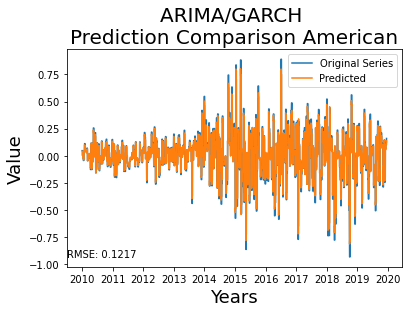

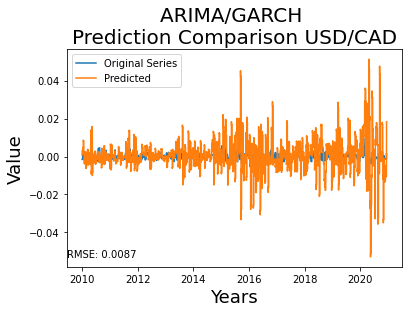

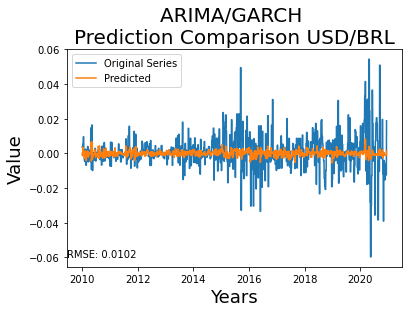


American Model Prediction Errors
  Error     Value
0    ME  0.000009
1   MAE  0.021084
2  RMSE  0.121652

USD/CAD Model Prediction Errors
  Error     Value
0    ME  0.000781
1   MAE  0.003615
2  RMSE  0.008736

USD/BRL Model Prediction Errors
  Error     Value
0    ME -0.000785
1   MAE  0.004314
2  RMSE  0.010235


In [10]:
plot_2_series(real=train_American_diff1,
            model=pred_American,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_American_diff1,pred_American)),
            title='ARIMA/GARCH \nPrediction Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_CAD_diff1,
            model=pred_BRL,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_CAD_diff1,pred_BRL)),
            title='ARIMA/GARCH \nPrediction Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_BRL_diff1,
            model=pred_CAD,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_BRL_diff1,pred_CAD)),
            title='ARIMA/GARCH \nPrediction Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(train_American_diff1,pred_American))
print("\nUSD/CAD Model Prediction Errors")
print(errors(train_USD_CAD_diff1,pred_BRL))
print("\nUSD/BRL Model Prediction Errors")
print(errors(train_USD_BRL_diff1,pred_CAD))

## Forecasting


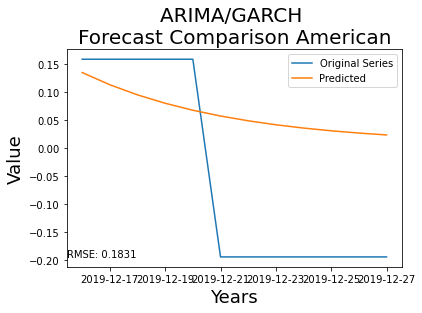

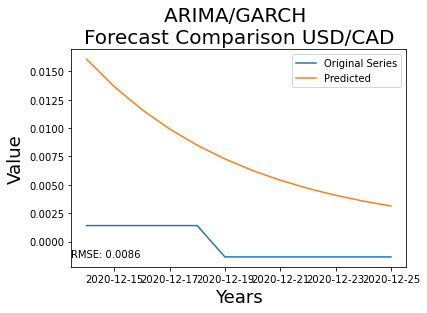

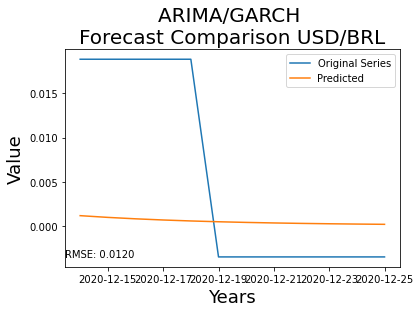


American Model Forecast Errors
  Error     Value
0    ME  0.110143
1   MAE  0.219871
2  RMSE  0.182837

USD/CAD Model Forecast Errors
  Error     Value
0    ME  0.008049
1   MAE  0.007345
2  RMSE  0.008564

USD/BRL Model Forecast Errors
  Error     Value
0    ME -0.005288
1   MAE  0.003941
2  RMSE  0.011995


In [11]:
arima_for_American = arima_American_diff1.predict(start=test_American_diff1.index.astype(str)[0],end=test_American_diff1.index.astype(str)[-1])
arima_for_BRL = arima_USD_BRL_diff1.predict(start=test_USD_BRL_diff1.index.astype(str)[0],end=test_USD_BRL_diff1.index.astype(str)[-1])
arima_for_CAD = arima_USD_CAD_diff1.predict(start=test_USD_CAD_diff1.index.astype(str)[0],end=test_USD_CAD_diff1.index.astype(str)[-1])

garch_for_American = garch_American_diff1.forecast(horizon=12)
garch_for_BRL = garch_USD_BRL_diff1.forecast(horizon=12)
garch_for_CAD = garch_USD_CAD_diff1.forecast(horizon=12)

for_American = arima_for_American.copy(deep=True)
for_BRL = arima_for_BRL.copy(deep=True)
for_CAD = arima_for_CAD.copy(deep=True)

for i in range(12):
    for_American[i] += garch_for_American.mean.iloc[-1][i]
    for_BRL[i] += garch_for_BRL.mean.iloc[-1][i]
    for_CAD[i] += garch_for_CAD.mean.iloc[-1][i]


plot_2_series(real=test_American_diff1,
            model=for_American,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_American_diff1,for_American)),
            title='ARIMA/GARCH \nForecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_CAD_diff1,
            model=for_BRL,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_CAD_diff1,for_BRL)),
            title='ARIMA/GARCH \nForecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_BRL_diff1,
            model=for_CAD,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_BRL_diff1,for_CAD)),
            title='ARIMA/GARCH \nForecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Forecast Errors")
print(errors(test_American_diff1,arima_for_American))
print("\nUSD/CAD Model Forecast Errors")
print(errors(test_USD_CAD_diff1,arima_for_BRL))
print("\nUSD/BRL Model Forecast Errors")
print(errors(test_USD_BRL_diff1,arima_for_CAD))